# SVD: Distance Matrix Job

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src')

import numpy as np
import pandas as pd

import logging
import warnings

from surprise import SVD

import util as ut
from logger import LoggerBuilder
from domain_context import DomainContext 

In [3]:
TEMP_PATH               = '../../temp'
RATING_MATRIX_PATH      = f'{TEMP_PATH}/rating_matrix'

HOST                    = 'http://localhost:8000'
API_TOKEN               = 'e3ff025094fe0ee474501bbeda0a2a44e80230c1'

GENERATE_RATING_MATRIX  = True

### Setup

In [4]:
!mkdir -p {TEMP_PATH}

In [5]:
LoggerBuilder.build()

In [6]:
warnings.filterwarnings('ignore')

In [7]:
ctx = DomainContext(API_TOKEN, HOST)

### Get interactions

2022-12-06 20:07:04,520 [INFO] - Page 1/3 - Interactions 50000/147681
2022-12-06 20:07:06,865 [INFO] - Page 2/3 - Interactions 100000/147681
2022-12-06 20:07:09,095 [INFO] - Page 3/3 - Interactions 147681/147681
2022-12-06 20:07:09,096 [INFO] - 147681 Total Interactions 


<Figure size 640x480 with 1 Axes>

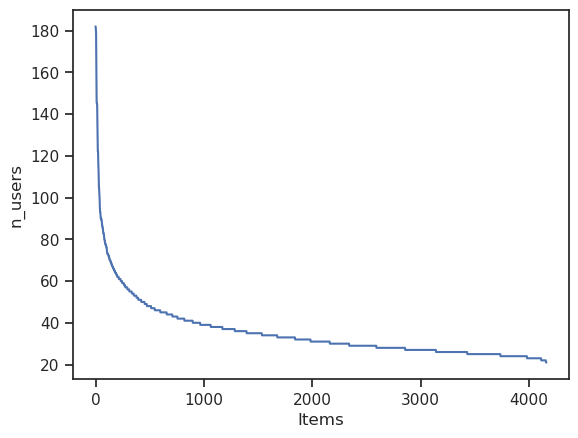

In [10]:
if GENERATE_RATING_MATRIX:
    interactions = ctx.interaction_service.find_all()
    ctx.interaction_service.plot_n_users_by_item(interactions)

### Compute Rating Matrix

In [13]:
if GENERATE_RATING_MATRIX:
    rating_matrix = ctx.rating_matrix_service.compute(interactions, model=SVD())
    ut.Picket.save(RATING_MATRIX_PATH, rating_matrix)
else:
    rating_matrix = ut.Picket.save(RATING_MATRIX_PATH)

2022-12-06 20:14:27,919 [INFO] Compute matrix: 99%
